In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import inspect

import torch
import torch.distributions as dist
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

SEED=3012024

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(torch.cuda.is_available())
# DEVICE = "cpu"

False


In [3]:
torch.manual_seed(SEED)


## using the provided resource as base architecture
#Simplest heriatical
class VAE(nn.Module):
    def __init__(self, hidden_dims, latent_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 2, "Insufficiently number of dimensions!"
        assert len(latent_dims) >= 2, "Insufficiently number of latent dimensions!"
        self.data_dim = data_dim
        self.device = device
        self.latent_dims = latent_dims

        # define IO

        # Forward x to (mu_0, var_0) to x'_0 to (mu_1, var_1) (for 2 latent dims)
        self.in_layer = nn.ModuleList([nn.Linear(data_dim, hidden_dims[0]) for dim in latent_dims])
        self.out_layer = nn.ModuleList([nn.Linear(hidden_dims[0], data_dim) for dim in latent_dims[:-1]])

        # hidden layer
        self.enc_h = nn.ModuleList([nn.Linear(hidden_dims[0], hidden_dims[1]) for dim in latent_dims])
        # define hidden and latent
        self.enc_mu = nn.ModuleList([nn.Linear(hidden_dims[1], latent_dim) for latent_dim in latent_dims])
        self.enc_sigma = nn.ModuleList([nn.Linear(hidden_dims[1], latent_dim) for latent_dim in latent_dims])
        # hidden layer decoder
        self.dec_h = nn.ModuleList([nn.Linear(latent_dim, hidden_dims[1]) for latent_dim in latent_dims[:-1]])
        self.dec_layer = nn.ModuleList([nn.Linear(hidden_dims[1], hidden_dims[0]) for dim in latent_dims[:-1]])



        # downward pass
        # (mu_1, var_1) to x''_0 to new (mu_0, var_0) to recon x (for 2 latent dims)
        self.in_layer_d = nn.ModuleList([nn.Linear(data_dim, hidden_dims[0]) for dim in latent_dims[:-1]])
        self.out_layer_d = nn.ModuleList([nn.Linear(hidden_dims[0], data_dim) for dim in latent_dims[::-1]])

        # hidden layer
        self.enc_h_d = nn.ModuleList([nn.Linear(hidden_dims[0], hidden_dims[1]) for dim in latent_dims[:-1]])
        # define hidden and latent
        self.enc_mu_d = nn.ModuleList([nn.Linear(hidden_dims[1], latent_dim) for latent_dim in latent_dims[:-1]]) # Switch array for more than 2 latent dims?
        self.enc_sigma_d = nn.ModuleList([nn.Linear(hidden_dims[1], latent_dim) for latent_dim in latent_dims[:-1]])
        # hidden layer decoder
        self.dec_h_d = nn.ModuleList([nn.Linear(latent_dim, hidden_dims[1]) for latent_dim in latent_dims[::-1]])
        self.dec_layer_d = nn.ModuleList([nn.Linear(hidden_dims[1], hidden_dims[0]) for dim in latent_dims[::-1]])

        self.to(device)

    def encode(self, x: torch.Tensor, level: int) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer[level](x))
        h2 = F.relu(self.enc_h[level](h1))
        return self.enc_mu[level](h2), self.enc_sigma[level](h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor, level: int) -> torch.Tensor:
        h3 = F.relu(self.dec_h[level](z))
        h4 = F.relu(self.dec_layer[level](h3))
        return torch.sigmoid(self.out_layer[level](h4))
     # downward pass
    def encode_d(self, x: torch.Tensor, level: int) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer_d[level](x))
        h2 = F.relu(self.enc_h_d[level](h1))
        return self.enc_mu_d[level](h2), self.enc_sigma_d[level](h2)

    def decode_d(self, z: torch.Tensor, level: int) -> torch.Tensor:
        h3 = F.relu(self.dec_h_d[level](z))
        h4 = F.relu(self.dec_layer_d[level](h3))
        return torch.sigmoid(self.out_layer_d[level](h4))




    def passdown(self, mus, log_vars):
        # Impliment for more than 2 latent dims
        pass

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mus_p = []
        logvars_p = []

        for level, latent_dim in enumerate(self.latent_dims):
            mu, logvar = self.encode(x.view(-1, self.data_dim), level)
            mus_p += [mu]
            logvars_p += [logvar]
            if latent_dim != self.latent_dims[-1]: #single sampling could impliment importance sampling here.
                z = self.reparameterize(mu, logvar)
                x = self.decode(z, level)
        for level, latent_dim in enumerate(self.latent_dims[:-1]):
            z = self.reparameterize(mu, logvar)
            x = self.decode_d(z, level)
            mu_q, logvar_q = self.encode_d(x.view(-1, self.data_dim), level)
            mu_p, logvar_p = mus_p[-(level+2)], logvars_p[-(level+2)]
            var_q, var_p = torch.exp(logvar_q),  torch.exp(logvar_p)
            mu = (mu_p/var_p + mu_q/var_q) / (1/var_q + 1/var_p)
            logvar = torch.log(1/(1/var_q + 1/var_p))
            if latent_dim == self.latent_dims[:-1][-1]: #single sampling could impliment importance sampling here.
                z = self.reparameterize(mu, logvar)
                return self.decode_d(z, level+1), mu, logvar, z


In [4]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(x)
        loss_val, ce, kld, normalization = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar, _ = model(x)
            test_loss_val, ce, kld, normalization = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [6]:
kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE=="cuda" else {}

batch_size = 128

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:
EPOCHS=40
clamp_threshold = 1e-4 # implemented in the original cb work

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50], latent_dims = [4,2]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Jeg har simplificeret udtrykket en smule og tilføjet ledet til loss-funktionen
def sumLogC(x, distance=0.01):
    mask = torch.isclose(x, torch.tensor(0.5), rtol=0, atol=distance)
    close = x[mask]
    not_close = x[~mask]
    # Taylor exspansion omkring 1/2, skal nok dobbeltjekkes
    logC_close = torch.log(2.0 + 8.0/3.0 * (close-0.5)**2.0 + 32.0/5.0 * (close-0.5)**4.0)
    # logC_close = torch.ones_like(x)*torch.log(torch.tensor(2.0)) # Man kunne måske bare tage dem der er lig 0.5, og sætte dem lige 2 #
    # logC_not_close = torch.log((torch.log(1.0-not_close) - torch.log(not_close))/(1.0-2.0*not_close))
    logC_not_close = torch.log(2 * torch.atanh(1- 2*not_close)/(1.0-2.0*not_close))
    return logC_close.sum() + logC_not_close.sum()


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x = x.view(-1, 784)
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    recon_x = torch.clamp(recon_x, clamp_threshold, 1-clamp_threshold) # implemented in the original cb work
    cb_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    normalization = (-1) * sumLogC(recon_x)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return cb_loss + normalization + KLD, cb_loss, KLD, normalization # = -ELBO

def q_sampler(size):
    return #do the sample thank u

def importance_sampling(p, q, q_sampler, f, size):
    z = q_sampler(size)
    norm_ratio_estimate = np.sum(p(z)/(kq(z)))
    return np.sum(p(z)/(kq(z))/norm_ratio_estimate * f(z))

train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=-0.4739331007003784
BCE=69533.40625 KLD=52.33656311035156
Train epoch=1 [3200/60000]	 loss=-1009.169677734375
BCE=44818.0078125 KLD=6161.0302734375
Train epoch=1 [6400/60000]	 loss=-1082.8612060546875
BCE=43485.5234375 KLD=1738.04150390625
Train epoch=1 [9600/60000]	 loss=-1120.501708984375
BCE=37515.98828125 KLD=1098.973388671875
Train epoch=1 [12800/60000]	 loss=-1112.9056396484375
BCE=39497.296875 KLD=1202.1358642578125
Train epoch=1 [16000/60000]	 loss=-1125.0565185546875
BCE=38095.140625 KLD=1373.677734375
Train epoch=1 [19200/60000]	 loss=-1146.44921875
BCE=36932.69140625 KLD=1128.42431640625
Train epoch=1 [22400/60000]	 loss=-1181.4739990234375
BCE=34664.390625 KLD=1611.220458984375
Train epoch=1 [25600/60000]	 loss=-1197.1448974609375
BCE=34029.58984375 KLD=1608.4652099609375
Train epoch=1 [28800/60000]	 loss=-1223.9752197265625
BCE=31000.34765625 KLD=1516.9390869140625
Train epoch=1 [32000/60000]	 loss=-1218.969970703125
BCE=33626.078125 KLD=1602.

[[-162863.4375, -164527.140625, -162422.5625, -161776.828125, -159320.296875, -162659.03125, -161546.484375, -162621.59375, -162876.5, -163234.484375, -162720.078125, -160482.078125, -162928.71875, -163453.140625, -163046.234375, -163190.34375, -160360.859375, -161545.90625, -163096.671875, -162537.671875, -162137.671875, -161522.71875, -162162.0, -163583.9375, -163305.828125, -162320.25, -163214.53125, -160298.703125, -163642.109375, -158373.625, -158296.390625, -165933.875, -162031.234375, -163638.484375, -159841.40625, -162460.1875, -163031.125, -161568.15625, -163481.578125, -165521.609375, -161041.6875, -162459.921875, -159478.609375, -162233.796875, -160832.640625, -158799.96875, -159602.6875, -152760.546875, -159424.546875, -159345.15625, -161244.328125, -162637.75, -159023.765625, -162637.40625, -166341.625, -165314.171875, -162092.734375, -164324.78125, -161172.234375, -164873.625, -156396.375, -153166.484375, -156042.75, -157778.71875, -153040.546875, -156959.90625, -154971.3

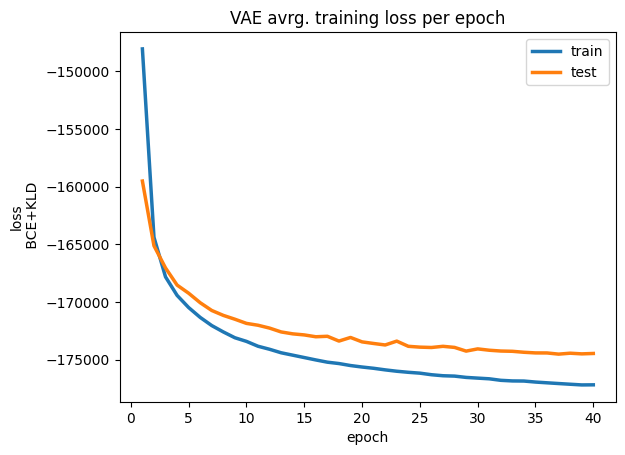

In [ ]:
print(test_loss_vals_total)
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
print([np.mean(ls) for ls in train_loss_vals_total][-1])
print([np.mean(ls) for ls in test_loss_vals_total][-1])
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [ ]:
# encode entries
latent_coordinates = []
for data in train_data:
    with torch.no_grad():
        # NOTE: we only obtain the mean for encoding and discard the log var
        _,_,_, z = model(torch.tensor(data[0]).to(DEVICE))
        z = z.cpu().detach().squeeze().numpy()
        latent_coordinates.append(z)
latent_coordinates = np.array(latent_coordinates).reshape(60000, -1)

<ipython-input-9-2a08dae18ef6>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,_,_, z = model(torch.tensor(data[0]).to(DEVICE))


In [ ]:
latent_coordinates = latent_coordinates.reshape(60000, -1)
train_labels = [data[1] for data in train_data]

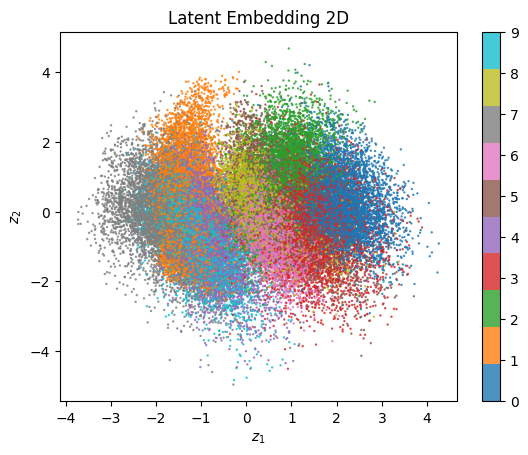

In [ ]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

### Visualization by Gauss CDF

In [ ]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([144, 2])

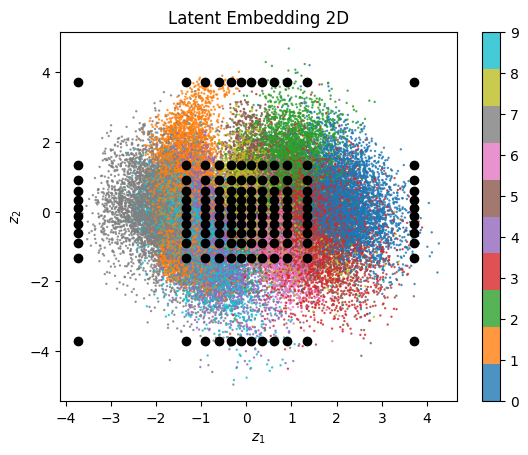

In [ ]:
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.colorbar()
plt.scatter(zz_gauss_cdf_vals[:,0], zz_gauss_cdf_vals[:,1], color='black')
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.title("Latent Embedding 2D")
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x50)

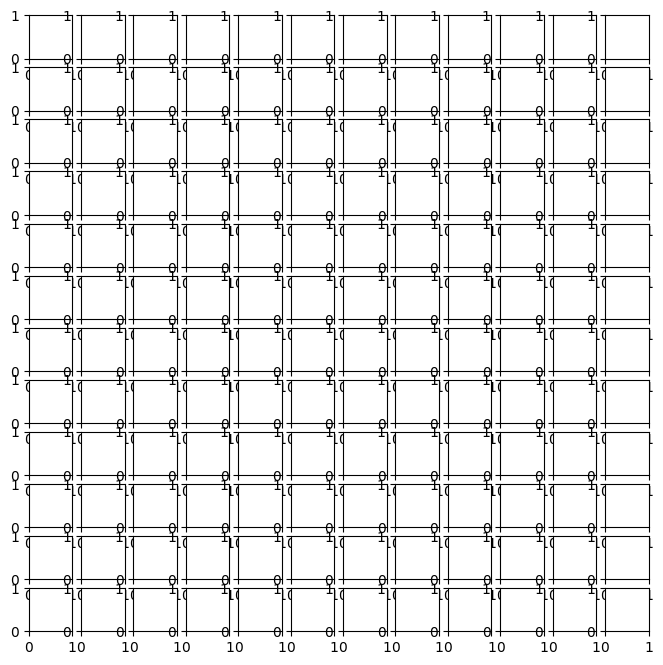

In [ ]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

def mu_cb(lamb):
    return lamb/(2*lamb-1) + 1/(2*torch.atanh(1- 2*lamb))


k = 0
for j in range(n_cols):
    for i in np.array(range(n_cols))[::-1]:
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model.decode_d(_zz.to(DEVICE), 1).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()

In [7]:
model = VAE(hidden_dims=[300, 50], latent_dims = [4,2])
model.load_state_dict(torch.load("./ladder_vae_200.model",map_location=torch.device('cpu')))


<All keys matched successfully>

In [75]:
latent_coordinates = []
for data in train_data:
    with torch.no_grad():
        # NOTE: we only obtain the mean for encoding and discard the log var
        _,_,_, z = model(torch.tensor(data[0]).to(DEVICE))
        z = z.cpu().detach().squeeze().numpy()
        latent_coordinates.append(z)
latent_coordinates = np.array(latent_coordinates).reshape(60000, -1)

C:\Users\phili\AppData\Local\Temp\ipykernel_148\3873608685.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,_,_, z = model(torch.tensor(data[0]).to(DEVICE))


In [76]:
train_labels = [data[1] for data in train_data]

[[-0.20609751 -0.64340009 -0.24095725 ... -0.09354976 -0.63248086
   0.22506422]
 [ 0.27212602  0.51848132 -0.73697347 ...  0.12927312  0.14523167
   0.2437257 ]]


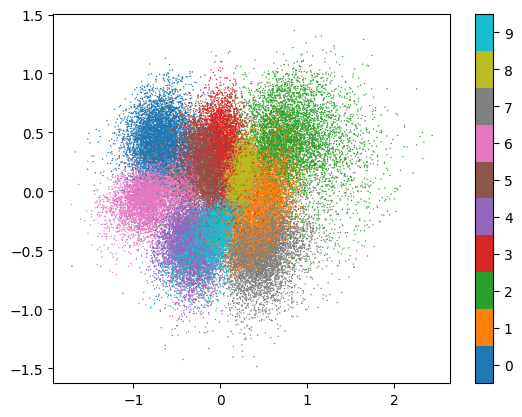

In [80]:
X_train = latent_coordinates.reshape(60000, -1)
# print(X_train)
y_train = train_labels
# Define latent space dimensions
m = 2
# Compute covariance matrix, eigenvectors and eigenvalues
cov = np.cov(X_train, rowvar=False)
eigvalues, eigvectors = np.linalg.eigh(cov)
eigvalues = np.round(eigvalues, 10)
eigvalues = np.flip(eigvalues)
eigvectors = np.flip(eigvectors, axis=1)

# Compute mu and variance
sigma2 = 1/(eigvalues.size-m) * np.sum(eigvalues[m:])
mu = np.mean(X_train, axis=0)

# Compute W and M
W = eigvectors[:,:m] @ (np.sqrt(np.diag(eigvalues[:m]) - sigma2 * np.identity(m)))
M = W.T @ W + sigma2 * np.identity(m)

# Compute expectations
expectations = np.linalg.inv(M) @ W.T @ (X_train - mu).T
print(expectations)
# Plot expectations
plt.scatter(*expectations, s = 1, c = y_train, cmap="tab10",
vmin=-0.5, vmax = 9.5, marker = "o", edgecolors="none")
cbar = plt.colorbar()
cbar.ax.set_yticks(range(10), range(10))
cbar.ax.set_ylim(-0.5, 9.5)
cbar.ax.tick_params(which = "minor", length = 0)
cbar.ax.tick_params(which = "major", length = 4)
plt.savefig("H_VAE_PPCA_trainset.png", dpi = 400, facecolor = "white")
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_148\492602751.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x,_,_,_ = model(torch.tensor(train_data[rand_idx][0]).to(DEVICE))


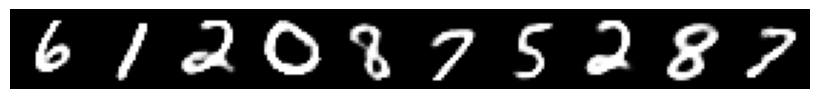

In [81]:
n_pics = 10
rand_list = np.random.randint(0,10000, size = 10)
fig, axes = plt.subplots(nrows=1, ncols=n_pics, figsize=(8,1))
for i, rand_idx in enumerate(rand_list):
    with torch.no_grad():
        # NOTE: we only obtain the mean for encoding and discard the log var
        recon_x,_,_,_ = model(torch.tensor(train_data[rand_idx][0]).to(DEVICE))
        axes[i].imshow(recon_x.reshape(28,28), cmap = "gray")
        axes[i].set_axis_off()
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.savefig("H_VAE_test_sample.png", dpi = 400)
plt.show()

In [50]:
clamp_threshold = 1e-4

def LogC(x, distance=0.01):
    LogC_tensor = torch.zeros_like(x)
    mask = torch.isclose(x, torch.tensor(0.5), rtol=0, atol=distance)
    close = x[mask]
    not_close = x[~mask]
    # Taylor exspansion omkring 1/2, skal nok dobbeltjekkes
    logC_close = torch.log(2.0 + 8.0/3.0 * (close-0.5)**2.0 + 32.0/5.0 * (close-0.5)**4.0)
    # logC_close = torch.ones_like(x)*torch.log(torch.tensor(2.0)) # Man kunne måske bare tage dem der er lig 0.5, og sætte dem lige 2
    # logC_not_close = torch.log((torch.log(1.0-not_close) - torch.log(not_close))/(1.0-2.0*not_close))
    logC_not_close = torch.log(2 * torch.atanh(1- 2*not_close)/(1.0-2.0*not_close))
    LogC_tensor[mask] = logC_close
    LogC_tensor[~mask] = logC_not_close
    return LogC_tensor

def marginal_likelihood(data, model, N=128):
    log_p_xs = torch.zeros(len(data))
    for i, (image, _) in enumerate(data):
        with torch.no_grad():
            _,mu, logvar,_ = model(image.to(DEVICE).view(-1, 784))
            mu = mu.cpu().detach()
            logvar = logvar.cpu().detach()
            var = torch.exp(logvar)
            q = dist.MultivariateNormal(mu, var * torch.eye(4))
            z = q.sample((N,))
            log_p_z = dist.MultivariateNormal(torch.zeros(4), torch.eye(4)).log_prob(z)
            log_q_z = q.log_prob(z)
            lam = model.decode_d(z.to(DEVICE), 1).cpu().detach()
            lam = torch.clamp(lam, clamp_threshold, 1-clamp_threshold) # Vi clamper for at undgå inf værdier i normaliseringskonstanten
            log_p_cb = torch.sum((-1) * F.binary_cross_entropy(lam, image.view(-1, 784).repeat(N, 1, 1), reduction="none") + LogC(lam), axis=2)
            log_something = log_p_cb + log_p_z - log_q_z
            log_p_x = -np.log(N) + torch.logsumexp(log_something, dim=0)
            log_p_xs[i] = log_p_x[0]
    return log_p_xs.mean()

In [51]:
# Det virker måske rigtigt nok. Den er ihvertfald omkring ELBO.
ml = marginal_likelihood(test_data, model, N=128)

In [52]:
print(ml)

tensor(1395.8752)
